## Installasi NLTK menggunakan `pip`

In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Mengimport library yang akan digunakan

In [ ]:
from collections import Counter

from nltk import download
from nltk import ngrams, FreqDist
from nltk.tokenize import RegexpTokenizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Mengunduh package `punkt` untuk NLTK. Library ini digunakan untuk memecah kalimat.

In [ ]:
download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Membuka Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Buka data set resep (sumber: [Kaggle](https://www.kaggle.com/datasets/canggih/indonesian-food-recipes))

In [ ]:
df_ayam = pd.read_csv("drive/MyDrive/Colab Notebooks/dataset/dataset-ayam.csv")
df_ikan = pd.read_csv("drive/MyDrive/Colab Notebooks/dataset/dataset-ikan.csv")
df_kambing = pd.read_csv("drive/MyDrive/Colab Notebooks/dataset/dataset-kambing.csv")
df_sapi = pd.read_csv("drive/MyDrive/Colab Notebooks/dataset/dataset-sapi.csv")
df_tahu = pd.read_csv("drive/MyDrive/Colab Notebooks/dataset/dataset-tahu.csv")
df_telur = pd.read_csv("drive/MyDrive/Colab Notebooks/dataset/dataset-telur.csv")
df_tempe = pd.read_csv("drive/MyDrive/Colab Notebooks/dataset/dataset-tempe.csv")
df_udang = pd.read_csv("drive/MyDrive/Colab Notebooks/dataset/dataset-udang.csv")

In [ ]:
df = pd.concat([df_ayam, df_ikan, df_kambing, df_sapi, df_tahu, df_telur, df_tempe, df_udang])
df = df.reset_index()

## Mencoba mengahpus karakter yang bukan alfabet atau angka

In [ ]:
df.Title = df.Title.str.replace(r"[^0-9a-zA-Z\s]", "", regex=True)

## Melakukan tokenization

In [ ]:
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
tokenized_ingredients = tokenizer.tokenize(" ".join(df.Ingredients.apply(lambda a: str(a).split("--")).apply(lambda b: " ".join(b))))

In [ ]:
pd.Series(ngrams(tokenized_ingredients, 1)).value_counts().head(25)

(bawang,)        26650
(merah,)         17833
(buah,)          17322
(siung,)         16498
(putih,)         15590
(secukupnya,)    14852
(sdm,)           12823
(sdt,)           10453
(daun,)           9075
(cabe,)           8787
(Secukupnya,)     7889
(garam,)          7581
(iris,)           7296
(potong,)         7087
(butir,)          6550
(Garam,)          6345
(bubuk,)          6015
(rawit,)          5810
(gula,)           5477
(Bumbu,)          5276
(air,)            5101
(goreng,)         5040
(Bawang,)         4847
(ruas,)           4784
(halus,)          4766
dtype: int64

In [ ]:
words_series = pd.Series([" ".join(y) for y in [tokenizer.tokenize(x) for x in df.Ingredients.apply(lambda a: str(a).replace("--", " "))]])

In [ ]:
words_series = words_series.str.replace(r"\bsecukupnya\b|\bsdm\b|\bsdt\b|\bsendok\b|\bkg\b|\bgr\b|\bbh\b|\bkg\b|\bdipotong\b|\bsaya\b|\baku\b", "", regex=True)

## Pembuatan data set training

In [ ]:
dish_and_words = pd.concat([df.URL, words_series], keys=["Recipe", "Words"], axis=1)

In [ ]:
dish_and_words

,Recipe,Words
0,/id/resep/4473027-ayam-woku-manado,Ekor Ayam Kampung potong Buah Jeruk Nipis Sdm ...
1,/id/resep/4471956-ayam-goreng-tulang-lunak,ayam sesuai selera jangan kecil ya batang se...
2,/id/resep/4473057-ayam-cabai-kawin,ayam buah cabai hijau besar buah cabai merah ...
3,/id/resep/4473023-ayam-geprek,daging ayam pakai fillet Secukupnya gula dan...
4,/id/resep/4427438-minyak-ayam,kulit ayam lemaknya siung bawang putih kating...
...,...,...
15636,/id/resep/3794442-udang-saus-mentega,udang segar buah bawang bombay kecil siung ba...
15637,/id/resep/3795267-jipang-tumis-udang,jipang pk jipang muda yg kecil potong korek...
15638,/id/resep/3794945-tumis-udang-tempe,siung bawang merah siung bawang putih buah cab...
15639,/id/resep/3794623-tumis-kacang-panjang-terong-...,Stgah ikat kacang panjang ku bli ribu d psr Te...


## Perhitungan kemiripan bahan-bahan dan evaluasi output

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer()

In [ ]:
def compute_similarity(a, b):
  tfidf = vectorizer.fit_transform([a, b])
  return ((tfidf * tfidf.T).toarray())[0,1]

<BarContainer object of 5 artists>

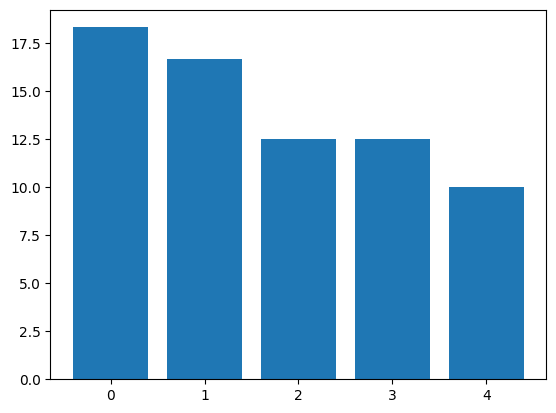

In [ ]:
tests = [
    ["udang", "tepung", "lada"],
    ["telur", "cabai hijau", "bawang putih"],
    ["kambing", "pete"],
    ["lobak", "kacang"],
    ["tahu", "selada"]
]
scores = []

for j in tests:
  sim = []
  for i, (recipe, words) in enumerate(zip(dish_and_words.Recipe, dish_and_words.Words)):
    sim.append((i, recipe, compute_similarity(words, " ".join(j))))

  sim.sort(key=lambda x: x[2], reverse=True)
  sim = sim[:5]
  score = 0
  for k in sim:
    for l in j:
      score += max(0, min(dish_and_words.loc[k[0], "Words"].find(l) + 1, 1))
  scores.append(score/len(j) * 5)

plt.bar(np.arange(len(scores)), scores)